In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import jnkepler
from jnkepler.jaxttv import *
from jnkepler.jaxttv.utils import elements_to_pdic, params_to_elements
from jax.config import config
import pkg_resources, glob
import numpyro, jax
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')
num_chains = 1
numpyro.set_host_device_count(num_chains)
print ('# jax device count:', jax.local_device_count())

# jax device count: 1


In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc
rc('text', usetex=True*0)

In [3]:
print ("JAX version:", jax.__version__)
print ("jnkepler version:", jnkepler.__version__)

JAX version: 0.3.23
jnkepler version: 0.0.1


### define tcobs, errorobs, p_init
- lists of length = (# of planets)
- elements of tcobs and errorobs: arrays of transit times and errors for each planet
- elements of p_init: (reasonably) good guesses for planets' mean periods

In [4]:
d = pd.read_csv("kep51/ttv.txt", delim_whitespace=True, header=None, names=['tnum', 'tc', 'tcerr', 'dnum', 'planum'])
tcobs = [jnp.array(d.tc[d.planum==j+1]) for j in range(3)]
errorobs = [jnp.array(d.tcerr[d.planum==j+1]) for j in range(3)]
p_init = [45.155305, 85.31646, 130.17809]

In [5]:
path = pkg_resources.resource_filename('jnkepler', 'data/')

In [6]:
params_test = np.loadtxt(glob.glob(path+"kep51*params.txt")[0])

In [7]:
elements, masses = params_to_elements(params_test, 3)
pdic = pd.DataFrame(elements_to_pdic(elements, masses))
print (pdic)

      pmass      period     ecosw     esinw  cosi  lnode         tic  \
0  3.300924   45.154108 -0.017186 -0.040699  -0.0    0.0  159.110265   
1  4.075007   85.314483  0.018882 -0.034824   0.0   -0.0  295.321017   
2  5.321454  130.184137  0.011666 -0.028107  -0.0   -0.0  212.023435   

        ecc     omega     lnmass      mass      cosw      sinw  
0  0.044179 -1.970355 -11.521534  0.000010 -0.389012 -0.921233  
1  0.039613 -1.073962 -11.310863  0.000012  0.476645 -0.879096  
2  0.030432 -1.177383 -11.043989  0.000016  0.383343 -0.923606  


### define timestep dt, start/end times of integration

In [8]:
t_start, t_end = 155., 2950.

In [17]:
dt_max = p_init[0] / 20.
dt_arr = np.array([dt_max/(2**(i-2)) for i in range(15)])

In [18]:
dt_arr

array([9.03106100e+00, 4.51553050e+00, 2.25776525e+00, 1.12888262e+00,
       5.64441312e-01, 2.82220656e-01, 1.41110328e-01, 7.05551641e-02,
       3.52775820e-02, 1.76387910e-02, 8.81939551e-03, 4.40969775e-03,
       2.20484888e-03, 1.10242444e-03, 5.51212219e-04])

In [19]:
def get_energy_diff_frac(dt):
    jttv = JaxTTV(t_start, t_end, dt) 
    jttv.set_tcobs(tcobs, p_init, errorobs=errorobs, print_info=False)
    return jttv.get_ttvs(elements, masses)[1]

In [20]:
de_arr = []
for dt in dt_arr:
    print (dt)
    de_arr.append(get_energy_diff_frac(dt))
de_arr = np.array(de_arr)

9.031061
4.5155305
2.25776525
1.128882625
0.5644413125
0.28222065625
0.141110328125
0.0705551640625
0.03527758203125
0.017638791015625
0.0088193955078125
0.00440969775390625
0.002204848876953125
0.0011024244384765624
0.0005512122192382812


In [21]:
de_arr

array([-6.68963761e-07,  2.27889583e-07,  1.69954202e-08,  4.34914127e-09,
        1.09971032e-09,  2.76470402e-10,  6.93043400e-11,  1.73352444e-11,
        4.25259827e-12,  1.09179332e-12,  1.56541446e-13, -1.67310610e-13,
       -2.85157453e-11, -2.32837083e-11, -3.69874131e-11])

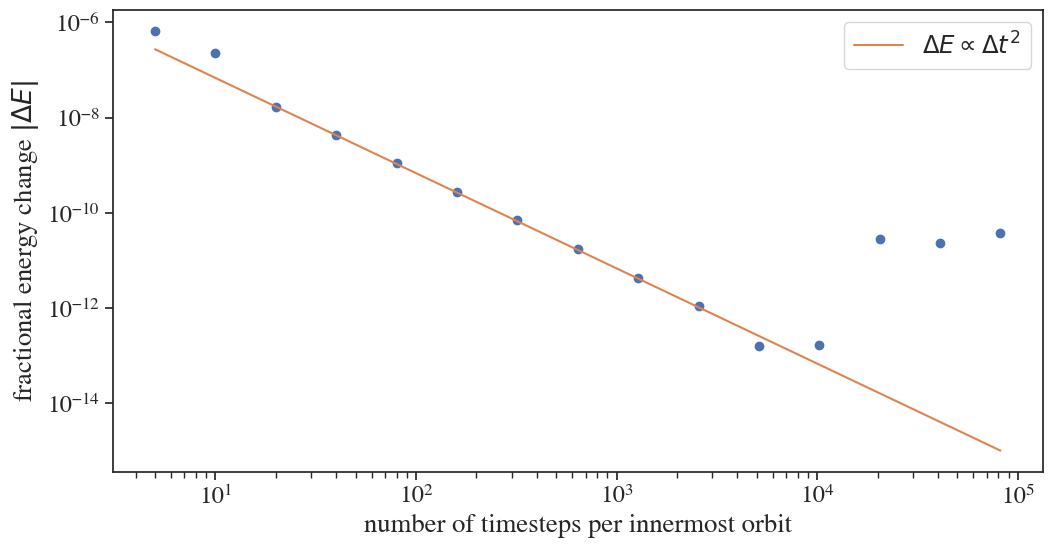

In [23]:
plt.xscale("log")
plt.yscale("log")
plt.ylabel("fractional energy change $|\Delta E|$")
#plt.xlabel("timestep $\Delta t$ in units of the innermost period")
#plt.plot(dt_arr/p_init[0], de_arr, 'o')
#plt.plot(dt_arr/p_init[0], 1.1*de_arr[0]*(dt_arr/dt_arr[0])**(2.), label='$\Delta E \propto \Delta t^2$')
plt.xlabel("number of timesteps per innermost orbit")
plt.plot(p_init[0]/dt_arr, np.abs(de_arr), 'o')
plt.plot(p_init[0]/dt_arr, de_arr[2]*(dt_arr/dt_arr[2])**(2.), label='$\Delta E \propto \Delta t^2$')
plt.legend(loc='upper right')